## Predicting YouTube Video's Popularity


**Steps:**

1. Acquired data provided @Kaggle for popular YouTube videos for Mexico and the USA and created dataframes
2. 'Publish_time' column was first chnaged from object to datetime data type and then broken into date/month/year/hour columns(features). Changed trending_date to datetime object. 
3. Created dataframe that contains only one ocurrance of the title with the latest statistics on the most recent day (most recent trending_date). Grouped the rows with title, selected first trending_date from the group and its related feature values. The latest trending_date contains cummulative stats for all the columns. 
4. EDA: Created distribution plots for likes, dislikes, cc and views to see how skewed the data is and how to scale for classification
5. Created a new feature called "Engagement Score (En)" defined as 
    En = (#likes + #dislikes + 2*#cc)
        This was used as a number that showed engagement level of people viewing the video. Giving more weight to cc because it takes more effort from a viewer to comment vs hit like/dislike buttons 
6. Added two additional features (length of title and length of channel_title)
7. Take log of views and newly created col En
8. Took top 10 words used in a 'Title' using NLP(text extraction using CountVectorizer) and added to data frame as 10 additional features.
9. Dropped 'channel_title','description','tags','trending_date','category_name','publish_time','likes','dislikes','comment_count','views','En','video_id','thumbnail_link', 'comments_disabled', 'ratings_disabled','video_error_or_removed', title
10. Using En_log and views_log performed Kmeans clustering. Scaled both features at equal level so that views(larger values) don't dominate how clusters are defined
11. Kmeans was performed with 3,4,5 neighbors. Knee method was also performed to see what the data suggest the number of neighbors should be. 
12. There is a clear boundary and some what equal class distribution when neighbors=3. 
13. Appended the class data (pop_class) to the data that has been wrangled (steps 1-8). 
14. Used KNN, RF, GB and AB to perform classification on training data and tested on test data. The target(dependent) variable is pop_class. 
15. RF showed best accuracy results. The confusion matrix, precision and recall scores were also collected. 



In [74]:
import cf_matrix as cf #contains make_confusion_matrix function from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
import YouTube_Data_Wrangling as dw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import holidays
import datetime
from datetime import date
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from collections import Counter
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import imblearn
from imblearn.over_sampling import SMOTE


In [2]:
## FUNCTIONS

def country_transformed(df):
    enc=preprocessing.LabelEncoder()
    enc=enc.fit(df.country)
    df.country=enc.transform(df.country)
    
def histograming(ax,df,title, xlabel):
    ax.hist(df, bins=20)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")


def prec_re(y_test, y_pred, classifier):
    ps,rs,fs,ss=precision_recall_fscore_support(y_test, y_pred, average=None,labels=[0,1,2])
    df=pd.DataFrame({'precision': ps, 'recall': rs, 'f-score': fs, 'sample_size': ss})
    return df.style.set_caption("Precision-Recall -"+ classifier).\
        format({'precision': "{:.2}", 'recall': "{:.2}", 'f-score': "{:.2}" })

def feature_importance(estimator, ax, title):
    
    feat_importances = pd.Series(estimator.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh', ax=ax, title=title)
    plt.title(title)
    
def histograming(ax,df,title, xlabel):
    ax.hist(df, bins=20)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency")

def country_transformed(df):
    enc=preprocessing.LabelEncoder()
    enc=enc.fit(df.country)
    df.country=enc.transform(df.country)


### DataFrame Creation

In [3]:
usa_df=pd.read_csv("USvideos.csv", parse_dates=[5])
mx_df=pd.read_csv("MXvideos.csv",engine='python')
usa_df['category_name']=usa_df['category_id'].map(dw.category_usa)
mx_df['category_name']=mx_df['category_id'].map(dw.category_mx)

usa_df['country']='USA'
mx_df['country']='Mexico'

df_combined_usa_mx=usa_df.append(mx_df)
df_combined_usa_mx.reset_index(inplace=True, drop=True)
df_combined_usa_mx.drop_duplicates(inplace=True)
df_combined_usa_mx.dropna(axis=0, how="any",inplace=True)
df_combined_usa_mx.reset_index(inplace=True, drop=True)

### Spliting publish_time into day/year/month/hour columns
### Changing trending_date into datetime object (yyyy-mm-dd)

In [4]:
#publish_time - breaking into year/month/day/weekday/time columns

df_combined_usa_mx['publish_time'] = pd.to_datetime(df_combined_usa_mx['publish_time'], utc=True)
df_combined_usa_mx['p_year']=df_combined_usa_mx['publish_time'].dt.year
df_combined_usa_mx['p_month'] =df_combined_usa_mx['publish_time'].dt.month
df_combined_usa_mx['p_day'] = df_combined_usa_mx['publish_time'].dt.day
df_combined_usa_mx["p_weekday"]=df_combined_usa_mx['publish_time'].dt.weekday
df_combined_usa_mx['p_time'] = df_combined_usa_mx['publish_time'].dt.hour

In [100]:
#df_combined_usa_mx.info() #76375

In [6]:
#Changing trending_date to datetime object

def tempdate(a):
    b=a.split(".")
    c=b[1]+b[2]+b[0]
    return c

df_combined_usa_mx['trending_date_new']=df_combined_usa_mx['trending_date'].apply(tempdate)
df_combined_usa_mx['trending_date_new']=pd.to_datetime(df_combined_usa_mx['trending_date_new'])
df_combined_usa_mx['trending_date']=df_combined_usa_mx['trending_date_new']
df_combined_usa_mx.drop(['trending_date_new'],axis=1,inplace=True)
df_combined_usa_mx['trending_date']=pd.to_datetime(df_combined_usa_mx['trending_date'])
#combined_usa_mx_df.info()
#Both dateTime columns have been converted to dateTime type successfully
###

### Dataframe with single entry of a unique video collected on latest trending_date

In [7]:
df=df_combined_usa_mx.sort_values('trending_date', ascending=False).groupby('title').first()
df.reset_index(inplace=True)

In [21]:
#df.info() #35843 entries

### EDA on the data 

In [14]:
#How are views/likes/dislikes/comment_count distributed distributed?

In [16]:
df_views_log=df['views_log']=np.log(df.views)
df_likes_log=np.log((df.likes)+1)
df_dlikes_log=np.log((df.dislikes)+1)
df_cc_log=np.log((df.comment_count)+1)

df_likes=df['likes']
df_dlikes=df['dislikes']
df_cc=df['comment_count']
df_views=df['views']

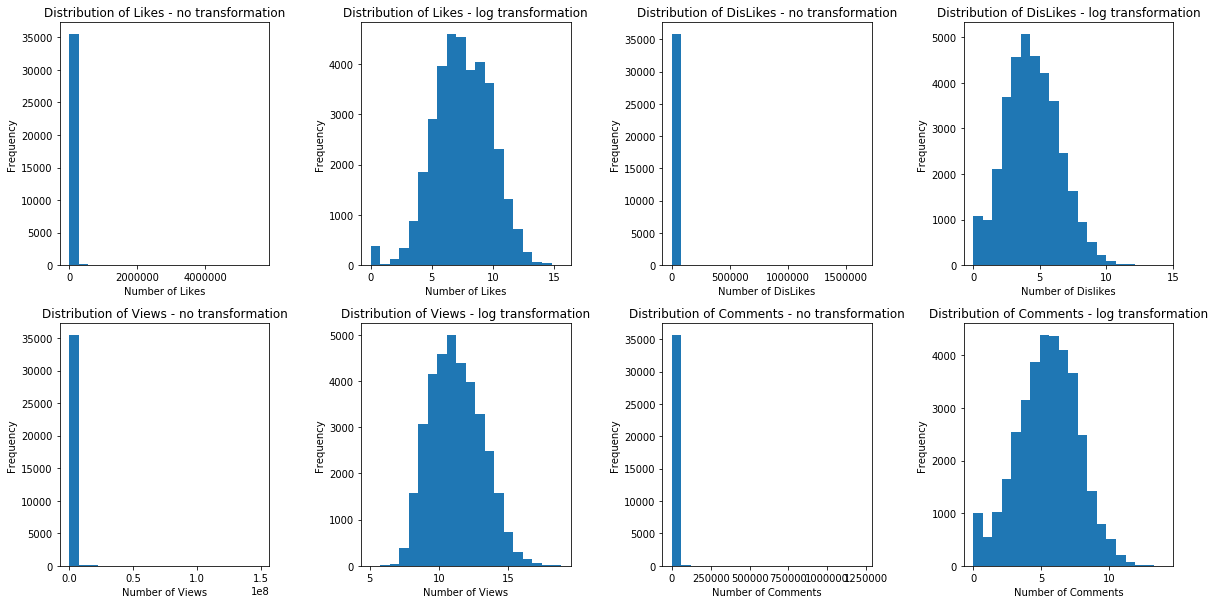

In [102]:
fig, ax =plt.subplots(2,4)
fig.set_size_inches(17, 8.5, forward=True)

histograming(ax[0,0],df_likes,"Distribution of Likes - no transformation", "Number of Likes") 
histograming(ax[0,1],df_likes_log,"Distribution of Likes - log transformation", "Number of Likes" )
histograming(ax[0,2],df_dlikes,"Distribution of DisLikes - no transformation", "Number of DisLikes" )
histograming(ax[0,3],df_dlikes_log,"Distribution of DisLikes - log transformation", "Number of Dislikes" )

histograming(ax[1,0],df_views,"Distribution of Views - no transformation", "Number of Views")
histograming(ax[1,1],df_views_log,"Distribution of Views - log transformation", "Number of Views" )
histograming(ax[1,2],df_cc,"Distribution of Comments - no transformation", "Number of Comments" )
histograming(ax[1,3],df_cc_log,"Distribution of Comments - log transformation", "Number of Comments" )

plt.tight_layout()

plt.savefig('distributions.jpg', bbox_inches = "tight")

In [18]:
# After log transformation views, likes, dislikes and cc are normally distributed. 

### Data Wrangling and Feature Engineering

In [24]:
# Adding En as (likes/dislikes/2*cc). Engagement Score. 

df['En']=df.likes+df.dislikes+2*df.comment_count

In [23]:
#comments_disabled=False rows are dropped as they unnessarly give smaller Engagemnt score 
rowstodel=df[df.comments_disabled==True].index
df.drop(rowstodel, inplace=True)


#ratings_disabled=False rows are dropped as they unnessarly give smaller Engagemnt score 
rowstodel1=df[df.ratings_disabled==True].index
df.drop(rowstodel1, inplace=True)


In [25]:
df.reset_index(inplace=True, drop=True)

In [26]:
df['title_len']=df.title.str.len()
df['channel_title_len']=df.channel_title.str.len()

In [27]:
df['views_log']=np.log(df.views)
df['En_log']=np.log((df.En+1))

### Text Extraction - 10 most used words in "title"

In [31]:
# Creating np array for text data "title"
text_data=np.array(df['title'])
#len(text_data)

In [32]:
# Create the bag of words feature matrix 
count = CountVectorizer()
bag_of_words = count.fit_transform(text_data)

In [103]:
#Get all the words in bag_of_words using .get_feature_names() method
feature_names = count.get_feature_names()
#len(feature_names)
type(feature_names)

list

In [34]:
#Create dataframe using bag_of_words.toarray() [change sparse matrix to array]
df_nlp=pd.DataFrame(bag_of_words.toarray(), columns=feature_names)

In [35]:
#create corpus of stopwords for "english" and "spanish"

stopwordsE = nltk.corpus.stopwords.words('english')
stopwordsS = nltk.corpus.stopwords.words('spanish')


#Using regular expression create Regex expression for stopwords

RE_stopwordsE = r'\b(?:{})\b'.format('|'.join(stopwordsE))
RE_stopwordsS = r'\b(?:{})\b'.format('|'.join(stopwordsS))

# drop all stopwords and replace some of the characters that are in
#bag_of_words but not are really words with a ' ' .

words = (df.title
           .str.lower()
           .replace([r'\d+|', r'\|',r'-|',r'&|',RE_stopwordsE,RE_stopwordsS,'\(', '\'', '\)', '\//',':', '/',',','#','!'], ['','','','','','','','','','','','','','',''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# Create DF by passing words to Counter and extracting top 11 used (common) words
rslt = pd.DataFrame(Counter(words).most_common(11),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt.index

Index(['vs', 'video', 'parte', 'completo', 'capitulo', 'hd', 'programa',
       'capã­tulo', 'hoy', 'official', 'vivo'],
      dtype='object', name='Word')

In [37]:
# From the index above, 'capã­tulo' is not actually recognized thats why took
#  11 common words rather than 10 to make 10 new features

#create word list using rslt.index:
word_list=['vs', 'video', 'parte', 'completo', 'capitulo', 'hd', 'programa', 'hoy', 'official', 'vivo']

#create dataframe of word_list
df_nlp_new=df_nlp[word_list]

In [40]:
#concat df_nlp_new with df adding new 10 columns from df_nlp_new 

df1=pd.concat([df,df_nlp_new], axis=1)
#df1.columns #10 new columns added

In [43]:
df1.drop(['title','video_id','trending_date','channel_title','publish_time','tags','views',
          'likes','dislikes','comment_count','thumbnail_link','En',
          'comments_disabled','ratings_disabled','video_error_or_removed', 'description', 'category_name'], axis=1, inplace=True)

In [52]:
#df1.info() #21 columns in the dataframe

## Clustering#######

In [53]:
# Prepocessing : Changing country to 0 and 1 

enc = preprocessing.LabelEncoder()
enc = enc.fit(df1['country'])
df1['country'] = enc.transform(df1['country'])

In [54]:
#Creating df_cluster with views_log and En_log to see clusters in the data

df_cluster=df1[['views_log','En_log']] # cluster with 2 features only 

In [55]:
#KMeans elbow method to check for optimal K

inertia = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_cluster)
    inertia.append(kmeans.inertia_)

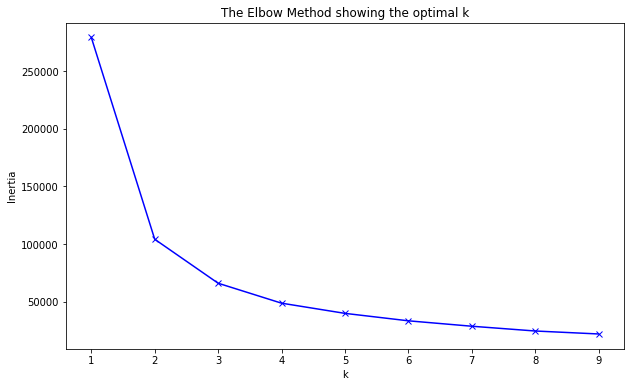

In [104]:
plt.figure(figsize=(10,6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')

plt.savefig('knee-elbow.jpg', bbox_inches = "tight")

##### From above graph it can be seen that k could be 3 or 4 or 5. Used all to create pop_classes but pop_class3 clusters were most defined and analysis was performed with pop_class3 only

In [68]:
kmeans3= KMeans(n_clusters=3, random_state=45).fit(df_cluster)
pop_class3 = kmeans3.predict(df_cluster)
centers3 = kmeans3.cluster_centers_

#kmeans4 = KMeans(n_clusters=4, random_state=0).fit(df_cluster)
#pop_class4 = kmeans4.predict(df_cluster)
#centers4 = kmeans4.cluster_centers_

#kmeans5 = KMeans(n_clusters=5, random_state=0).fit(df_cluster)
#pop_class5 = kmeans5.predict(df_cluster)
#centers5 = kmeans5.cluster_centers_

In [69]:
df1['pop_class3']=pop_class3
#df['pop_class4']=pop_class4
#df['pop_class5']=pop_class5

#pop_class4 and 5 make the classes quite unbalanced. Delete pop_class4 and 5 later

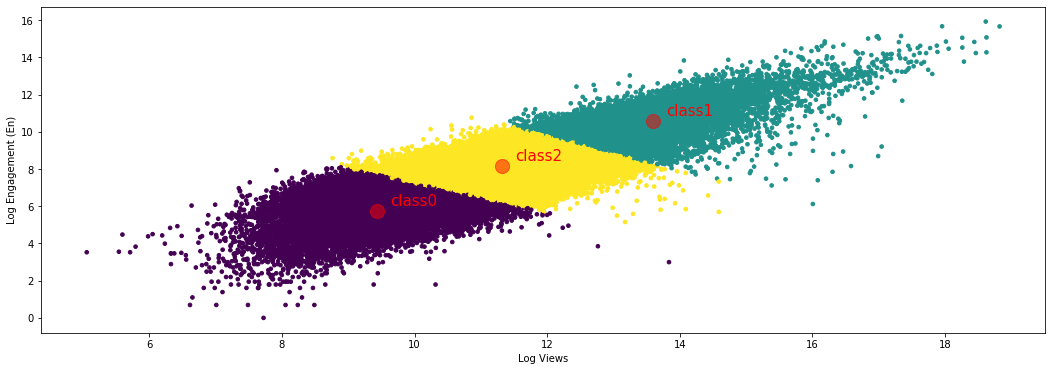

In [108]:
#See the clusters on the data with 3 classes

fig, ax = plt.subplots(figsize=(18,6))
ax.scatter(df_cluster['views_log'],df_cluster['En_log'], c=pop_class3, cmap='viridis', s=13)
ax.scatter(centers3[:, 0], centers3[:, 1], c='red', s=200, alpha=0.5)
#plt.colorbar(sc)
plt.xlabel("Log Views")
plt.ylabel("Log Engagement (En)")



y=centers3[:,1]
x=centers3[:,0]
n = ['class0','class1', 'class2']

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]+0.2, y[i]+0.3), fontsize=15, color='r')
plt.savefig('class_distribution.jpg', bbox_inches = "tight")


In [71]:
class_distribution=pd.DataFrame(df1.groupby(['pop_class3'])['category_id'].count())
class_distribution

,category_id
pop_class3,
0,12150
1,9152
2,13851


1. class 1 - views from 1.2M (e14 = 1202604.2841648) and onwards
2. class 2 - views from 0.2M (e12 = 162754.791419) to under 1.2M 
3. class 0 - views under 0.2M 

1. class 1 - engagement Score (En)is with class 0 videos around 60K and onwards {likes/dislikes/2*cc (e11 = 59874.141715198)}
2. class 2 - engagement score (En) is within 2900 to under 60K (e8 = 2980.9579870417 to e11)
3. class 0 - engagement score (En) is within 0 to less then 2900 

Commentary:
Majority of the videos are in class 2 as can be seen by above table i.e. most videos from 2017/2018 got views between (0.2M and 1.2M) and En between 2900 and 60K 


In [72]:
df1.drop(['views_log','En_log'], axis=1, inplace=True)

## Classification  with imbalanced class data

In [75]:
X=df1.drop(['pop_class3'], axis=1) #creating dataframe with all the feature except 'pop_class3' (target)

In [76]:
y=df1['pop_class3'] #target y array

In [77]:
# see the distributions of the classes before SMOTE (Synthetic Minority Oversampling Technique)
counter = Counter(y)
counter

Counter({0: 12150, 1: 9152, 2: 13851})

In [78]:
X_train,X_test, y_train, y_test =train_test_split(X,y, random_state=0)

In [79]:
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [81]:
# see the distributions of the classes after SMOTE
counter = Counter(y_train)
counter

Counter({2: 10379, 1: 10379, 0: 10379})

In [82]:
#X_train and y_train are ready for classification training

## 1. KNN

In [83]:
param_grid={'n_neighbors': np.arange(1,50)}

knn=KNeighborsClassifier()

knn_cv=GridSearchCV(knn,param_grid)

knn_cv.fit(X_train, y_train)

y_pred_knn=knn_cv.predict(X_test)

In [84]:
knn_cv.best_score_, knn_cv.best_params_, knn_cv.best_estimator_

(0.5834242162732395, {'n_neighbors': 1}, KNeighborsClassifier(n_neighbors=1))

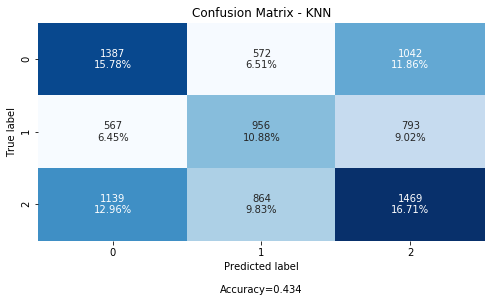

In [109]:
#confusion(y_test, y_pred_knn, "KNN")

cm=confusion_matrix(y_test, y_pred_knn,  labels=[0, 1, 2])
cf.make_confusion_matrix(cm, figsize=(8,4), cbar=False, title='Confusion Matrix - KNN')
plt.savefig('CM-KNN.jpg', bbox_inches = "tight")
#Accuracy is sum of diagonal divided by total observations

In [119]:
prec_re(y_test,y_pred_knn, 'KNN')

,precision,recall,f-score,sample_size
0,0.45,0.46,0.46,3001
1,0.4,0.41,0.41,2316
2,0.44,0.42,0.43,3472


array([0.46217927, 0.41278066, 0.42309908])

## 2. Random Forest

In [87]:
param_grid = [
    {
    'n_estimators' : list(range(10,101,10)),
    'max_features': list(range(4,8,2)), 
    'max_depth'    : [2, 3, 5, 10, 20],
    } 
]

RF=RandomForestClassifier()
RF_cv=GridSearchCV(RF, param_grid, cv=5)
RF_cv.fit(X_train, y_train)

y_pred_RF=RF_cv.predict(X_test)


In [88]:
RF_cv.best_score_, RF_cv.best_estimator_, RF_cv.best_params_

(0.6390791948667822,
 RandomForestClassifier(max_depth=20, max_features=6),
 {'max_depth': 20, 'max_features': 6, 'n_estimators': 100})

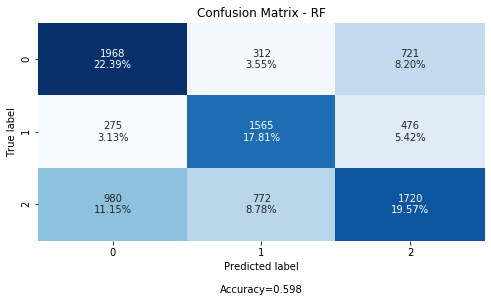

In [110]:
cm=confusion_matrix(y_test, y_pred_RF,  labels=[0, 1, 2])
cf.make_confusion_matrix(cm, figsize=(8,4), cbar=False, title='Confusion Matrix - RF')
plt.savefig('CM-RF.jpg', bbox_inches = "tight")
#Accuracy is sum of diagonal divided by total observations

In [118]:
prec_re(y_test,y_pred_RF, 'Random Forest')

,precision,recall,f-score,sample_size
0,0.61,0.66,0.63,3001
1,0.59,0.68,0.63,2316
2,0.59,0.5,0.54,3472


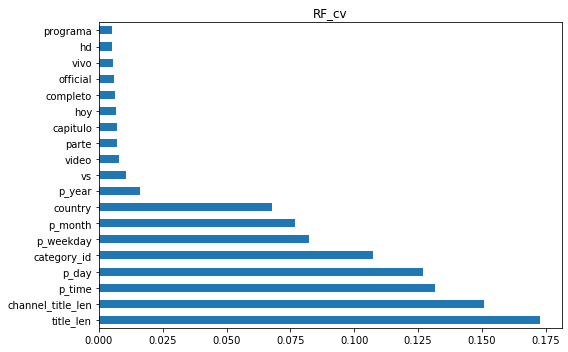

In [90]:
#Feature Importance (RF)
fig, axes=plt.subplots(1,1, figsize=(8,5))
feature_importance(RF_cv.best_estimator_, axes, 'RF_cv')
plt.tight_layout()

### Notes on Precision/Recall/Fscore/SS

#Compute precision, recall, F-Score and support for each class

#Precision quantifies the number of positive class predictions that actually belong to the positive class. 
#Recall quantifies the number of positive class predictions made out of all positive examples in the dataset. 
#F-Score provides a single score that balances both the concerns of precision and recall in one number

#Precision talks about how precise/accurate your model is out of those predicted positive,how many of them are actual positive.

## 3. Gradient Boost

In [92]:
param_grid=[{'n_estimators':list(range(20,100,10))}]
gb=GradientBoostingClassifier()

gb_cv=GridSearchCV(gb,param_grid)
gb_cv.fit(X_train, y_train)

y_pred_gb=gb_cv.predict(X_test)

In [93]:
gb_cv.best_score_, gb_cv.best_params_ 

(0.5484464241381952, {'n_estimators': 90})

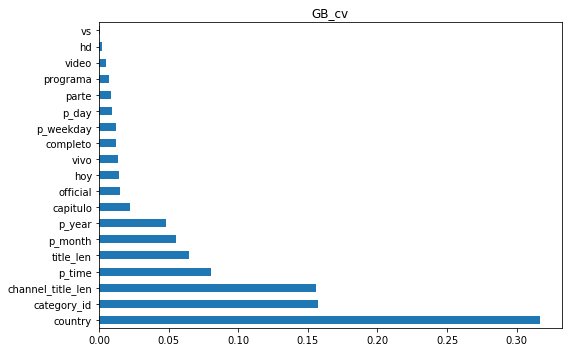

In [94]:
#Feature Importance (GB)
fig, axes=plt.subplots(1,1, figsize=(8,5))
feature_importance(gb_cv.best_estimator_, axes, 'GB_cv')
plt.tight_layout()

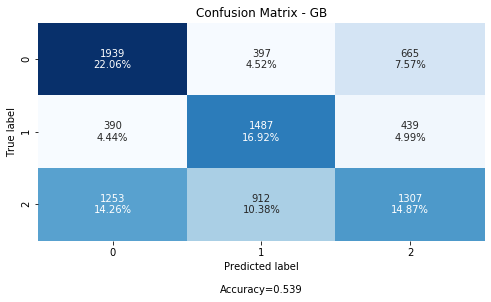

In [111]:
#confusion(y_test, y_pred_gb, "Gradient Boost")
cm=confusion_matrix(y_test, y_pred_gb,  labels=[0, 1, 2])
cf.make_confusion_matrix(cm, figsize=(8,4), cbar=False, title='Confusion Matrix - GB')
plt.savefig('CM-GB.jpg', bbox_inches = "tight")

In [117]:
prec_re(y_test,y_pred_gb, 'Gradient Boost')

,precision,recall,f-score,sample_size
0,0.54,0.65,0.59,3001
1,0.53,0.64,0.58,2316
2,0.54,0.38,0.44,3472


## 4. AdaBoost

In [97]:
param_grid=[{'n_estimators':list(range(100,150,10))}]


ab=AdaBoostClassifier()
ab_cv=GridSearchCV(ab,param_grid)
ab_cv.fit(X_train, y_train)
y_pred_ab=ab_cv.predict(X_test)

In [225]:
ab_cv.best_score_, ab_cv.best_params_ 

(0.5225925583915594, {'n_estimators': 140})

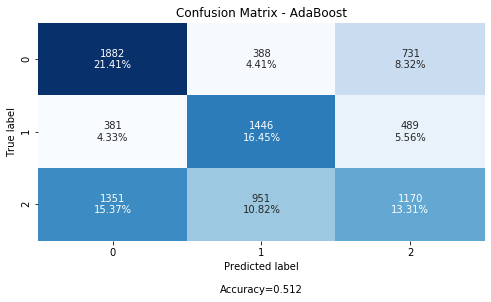

In [112]:
#confusion(y_test, y_pred_ab, "AdaBoost")

cm=confusion_matrix(y_test, y_pred_ab,  labels=[0, 1, 2])
cf.make_confusion_matrix(cm, figsize=(8,4), cbar=False, title='Confusion Matrix - AdaBoost')
plt.savefig('CM-AB.jpg', bbox_inches = "tight")


In [116]:
prec_re(y_pred_ab,y_test, 'AdaBoost')

,precision,recall,f-score,sample_size
0,0.63,0.52,0.57,3614
1,0.62,0.52,0.57,2785
2,0.34,0.49,0.4,2390


# Accuracy_Scores:

In [124]:
my_dict={'KNN':'{:.2f}'.format(knn_cv.best_score_*100), 
         
         'RandomForest': '{:.2f}'.format(RF_cv.best_score_*100), 
         
         'Gradient Boost': '{:.2f}'.format(gb_cv.best_score_*100),
         
         'AdaBoost': '{:.2f}'.format(ab_cv.best_score_*100)
        }
score_df=pd.DataFrame(list(my_dict.items()),
                      columns=['Model','Best_Score'])
score_df.sort_values(by='Best_Score', ascending=False)

,Model,Best_Score
1,RandomForest,63.91
0,KNN,58.34
2,Gradient Boost,54.84
3,AdaBoost,52.65


### not used code 
def confusion(y_test, y_pred,title):

    ax = plt.axes()
    
    cm=confusion_matrix(y_test, y_pred,  labels=[0, 1, 2], normalize='all')
    cm=confusion_matrix(y_test, y_pred,  labels=[0, 1, 2])

    #df = pd.DataFrame(cm*100,range(3), range(3))
    df = pd.DataFrame(cm, range(3), range(3))

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
    ax.set_title(title)
    plt.show()  

In [132]:
y_pred_ab.shape

(8789,)